In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from auxiliar_func import preprocessing, downsampling, cross_validation
from plot_func import *

In [2]:
df = pd.read_csv('Census-Income-KDD.csv')
target = 'income_50k'
df_tr, df_te = train_test_split(df, test_size=0.3, random_state=42)

In [3]:
params = {
    'scaling': ['minmax', 'standard', None],
    'imputation': ['mode', 'nancat'],
    'cat_age': [True, False],
    'target_freq': [0.8, 0.9]
}

results = pd.DataFrame(columns=['scaling', 'imputation', 'cat_age', 'target_freq', 'accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

for combination in list(itertools.product(*params.values())):
    print(f"Adjusting for {combination}")
    par_tr = {k:v for k,v in zip(params.keys(), combination)}
    par_tr['remove_duplicates'] = True

    # we remove the parameter that modifies the test dataset
    par_te = par_tr.copy()
    par_te['remove_duplicates'] = False
    par_te['target_freq'] = None

    logreg = LogisticRegression(max_iter=1000, random_state=42, solver='newton-cholesky')

    cross_val_results = cross_validation(logreg, df_tr, par_tr, par_te, cv = 4,
                                       scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])
    results = pd.concat([results, pd.DataFrame([list(combination) + list(cross_val_results.values())],
                                                  columns=['scaling', 'imputation', 'cat_age', 'target_freq', 'accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])])
    
results.to_csv('results_log_regression.csv', index=False)

Adjusting for ('minmax', 'mode', True, 0.8)


## Cross validation to test the preprocessing parameters

In [4]:
scaling = ['minmax', 'standard', None]
imputation = ['mode', 'nancat']
cat_age = [True, False]
downsampling_freq = [0.8, 0.9]

results = pd.DataFrame(columns=['scaling', 'imputation', 'cat_age', 'downsampling_freq', 'accuracy', 'precision', 'recall', 'f1_score'])

for s, i, c, d in itertools.product(scaling, imputation, cat_age, downsampling_freq):
    print(f"Adjusting for scaling: {s}, imputation: {i}, cat_age: {c}, downsampling_freq: {d}")

    df_tr_pre = preprocessing(df_tr, scaling=s, imputation=i, cat_age=c)
    df_tr_pre = downsampling(df_tr_pre, target_freq=d)
    df_te_pre = preprocessing(df_te, scaling=s, imputation=i, remove_duplicates=False, cat_age=c)

    df_tr_pre, df_te_pre = df_tr_pre.align(df_te_pre, join='left', axis=1, fill_value=0)

    X_train, y_train = df_tr_pre.drop(target, axis=1), df_tr_pre[target]
    X_test, y_test = df_te_pre.drop(target, axis=1), df_te_pre[target]

    # adjust a logistic regression model to the data
    logreg = LogisticRegression(max_iter=1000, random_state=42, solver='newton-cholesky')
    
    # cross_val_results = pd.DataFrame(cross_validate(logreg, X_train, y_train, cv = 4, 
    #                         scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
    
    # results = pd.concat([results, pd.DataFrame({'scaling': s, 'imputation': i, 'cat_age': c, 'downsampling_freq': d,
    #                                             'accuracy': cross_val_results['test_accuracy'].mean(),
    #                                             'precision': cross_val_results['test_precision_macro'].mean(),
    #                                             'recall': cross_val_results['test_recall_macro'].mean(),
    #                                             'f1_score': cross_val_results['test_f1_macro'].mean()}, index=[0])], ignore_index=True)
    break


results.to_csv('results_log_regression.csv', index=False)

Adjusting for scaling: minmax, imputation: mode, cat_age: True, downsampling_freq: 0.7
   fit_time  score_time  test_accuracy  test_f1_macro  test_precision_macro   
0  3.267559    0.100888       0.868861       0.840268              0.849100  \
1  3.513533    0.069065       0.852635       0.821056              0.828202   
2  3.786678    0.102788       0.861504       0.831354              0.839888   
3  3.458833    0.072014       0.866280       0.838241              0.844192   
4  3.029094    0.079997       0.859628       0.829219              0.837333   

   test_recall_macro  
0           0.832906  
1           0.814989  
2           0.824247  
3           0.833019  
4           0.822420  


In [3]:
df_tr_pre = preprocessing(df_tr, scaling=None, imputation='mode', cat_age=False, target_freq=0.8)
df_te_pre = preprocessing(df_te, scaling=None, imputation='mode', remove_duplicates=False, cat_age=False)

df_tr_pre, df_te_pre = df_tr_pre.align(df_te_pre, join='left', axis=1, fill_value=0)

In [4]:
df_tr_pre.shape, df_te_pre.shape

((43975, 474), (59857, 474))

## Adjusting a logistic regression model

In [15]:
X_train, y_train = df_tr_pre.drop(target, axis=1), df_tr_pre[target]
X_test, y_test = df_te_pre.drop(target, axis=1), df_te_pre[target]

# adjust a logistic regression model to the data
logreg = LogisticRegression(max_iter=1000, random_state=42, solver='newton-cholesky')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

### Accuracy metrics:

Accuracy score:  0.9356299179711646


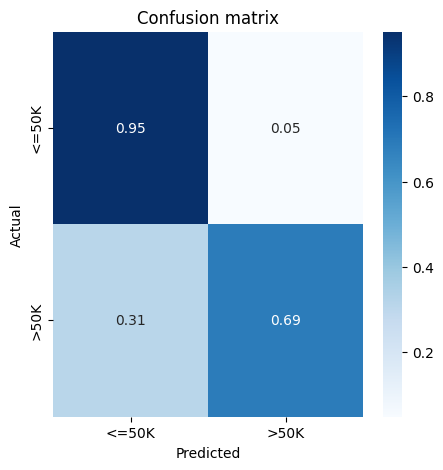

In [16]:
print('Accuracy score: ', accuracy_score(y_test, y_pred))
plot_conf_matrix(y_test, y_pred)